# Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.pandas.set_option("display.max_columns", None)

In [3]:
data = pd.read_csv(r"./dataset/x_train.csv")

print(data.shape)
data.head()

(15360, 12)


,Unnamed: 0,cfo_demod,gain_imb,iq_imb,or_off,quadr_err,m_power,ph_err,mag_err,evm,Tosc,Tmix
0,0,592.234802,0.048079,-35.082729,-28.560846,1.993170,-0.499721,1.107926,1.507550,2.423943,39.9,47.6
1,1,-103.302032,-0.019917,-29.946953,-35.798664,-3.642311,-0.928193,1.236059,2.741568,3.458056,14.8,23.1
2,2,-582.331299,0.036379,-32.096672,-31.905628,2.835839,-1.272485,1.282163,2.140096,3.013522,42.5,48.6
3,3,-630.611267,0.063928,-38.216297,-30.084171,1.346316,-0.596438,1.154848,1.093465,2.254514,26.1,35.4
4,4,-415.526978,-0.055761,-29.180740,-36.601025,-3.963526,0.113055,1.498889,3.608737,4.286684,24.2,40.8


In [4]:
# Dropping column 'Unnamed: 0' as long as it represents only id
data.drop('Unnamed: 0', axis=1, inplace=True)
data.shape

(15360, 11)

Wireless transmitters dataset consists of 15360 samples

### Analysis
#### Following columns will be analysed:
1. Target variables
2. Variable types (categorical and numerical)
3. Missing data
4. Numerical variables:
    * Discrete
    * Continuous
    * Distributions
    * Transformations
5. Categorical variables
    * Cardinality
    * Rare Labels
    * Special mappings
6. Additional Reading Resources

### Ad 1) Explorating target

In [5]:
targets = pd.read_csv(r"./dataset/y_train.csv")
targets.drop('Unnamed: 0', axis=1, inplace=True)
targets.head


<bound method NDFrame.head of        target
0           5
1           1
2           6
3           3
4           2
...       ...
15355       3
15356       8
15357       7
15358       7
15359       5

[15360 rows x 1 columns]>

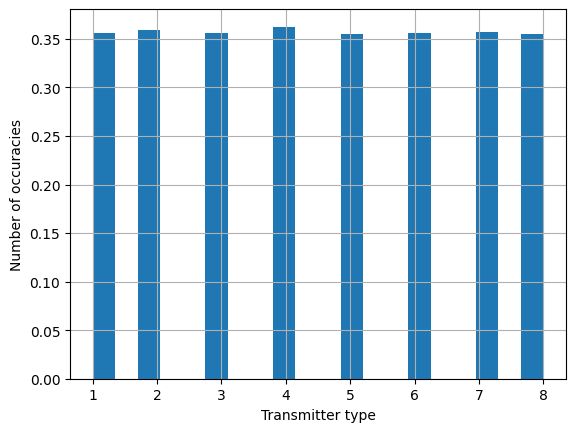

In [6]:
targets['target'].hist(bins=20, density=True)
plt.ylabel("Number of occuracies")
plt.xlabel("Transmitter type")
plt.show()

Based on graph abowe it seems like transmitters has normal distribution, there wont be no need for any compensations

### ad 2) Variable types

In [7]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
len(cat_vars)
# Seem there are no categorical variables

0

In [8]:
num_vars = [
    var for var in data.columns if var not in cat_vars
]

len(num_vars)
# All columns are numerical

11

### ad 3) Missing data

In [9]:
# list of variables containing missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

data[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

Dataset doesnt seem to contain any missing values

### ad 4) Continuous variables

In [10]:
print("Number of numerical variables:", len(num_vars))

data[num_vars].head()

Number of numerical variables: 11


,cfo_demod,gain_imb,iq_imb,or_off,quadr_err,m_power,ph_err,mag_err,evm,Tosc,Tmix
0,592.234802,0.048079,-35.082729,-28.560846,1.993170,-0.499721,1.107926,1.507550,2.423943,39.9,47.6
1,-103.302032,-0.019917,-29.946953,-35.798664,-3.642311,-0.928193,1.236059,2.741568,3.458056,14.8,23.1
2,-582.331299,0.036379,-32.096672,-31.905628,2.835839,-1.272485,1.282163,2.140096,3.013522,42.5,48.6
3,-630.611267,0.063928,-38.216297,-30.084171,1.346316,-0.596438,1.154848,1.093465,2.254514,26.1,35.4
4,-415.526978,-0.055761,-29.180740,-36.601025,-3.963526,0.113055,1.498889,3.608737,4.286684,24.2,40.8


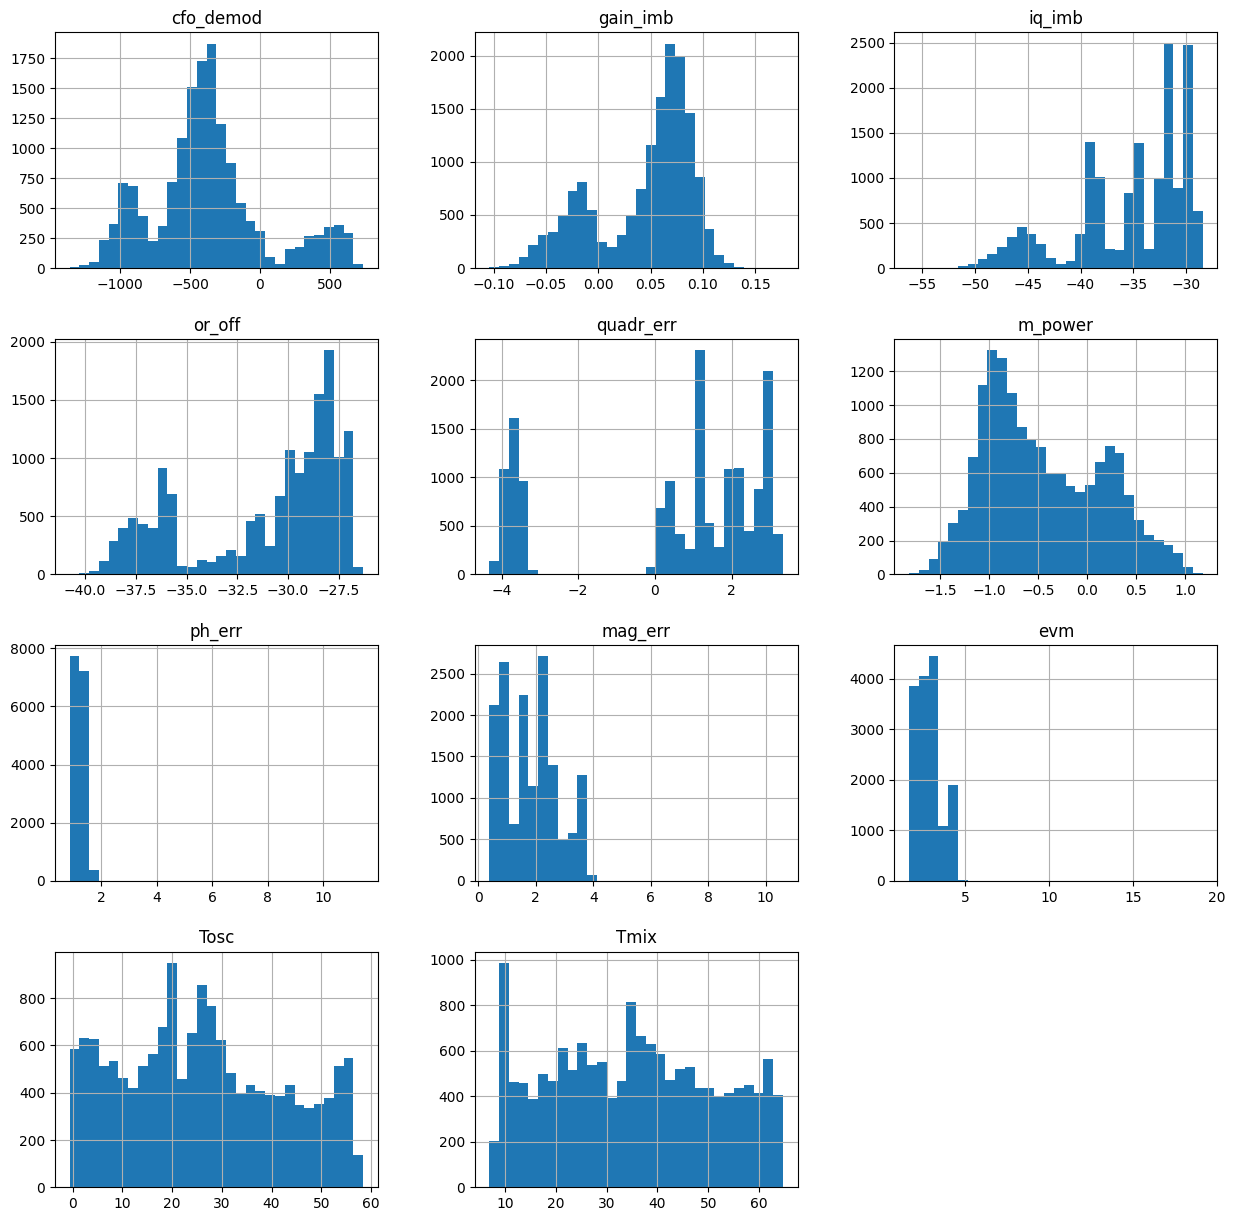

In [11]:
data[num_vars].hist(bins=30, figsize=(15, 15))
plt.show()

We can see the variables are not normally distributed. There are no few skewed classes.
It seems like some of the variables are already spreaded evenly like Tosc, Tmix.

In [12]:
cont_vars = [
    'ph_err',
    'cfo_demod',
    'gain_imb',
    'iq_imb',
    'or_off',
    'quadr_err',
    'm_power',
    'mag_err',
    'evm',
    # 'Tosc',
    # 'Tmix',
]

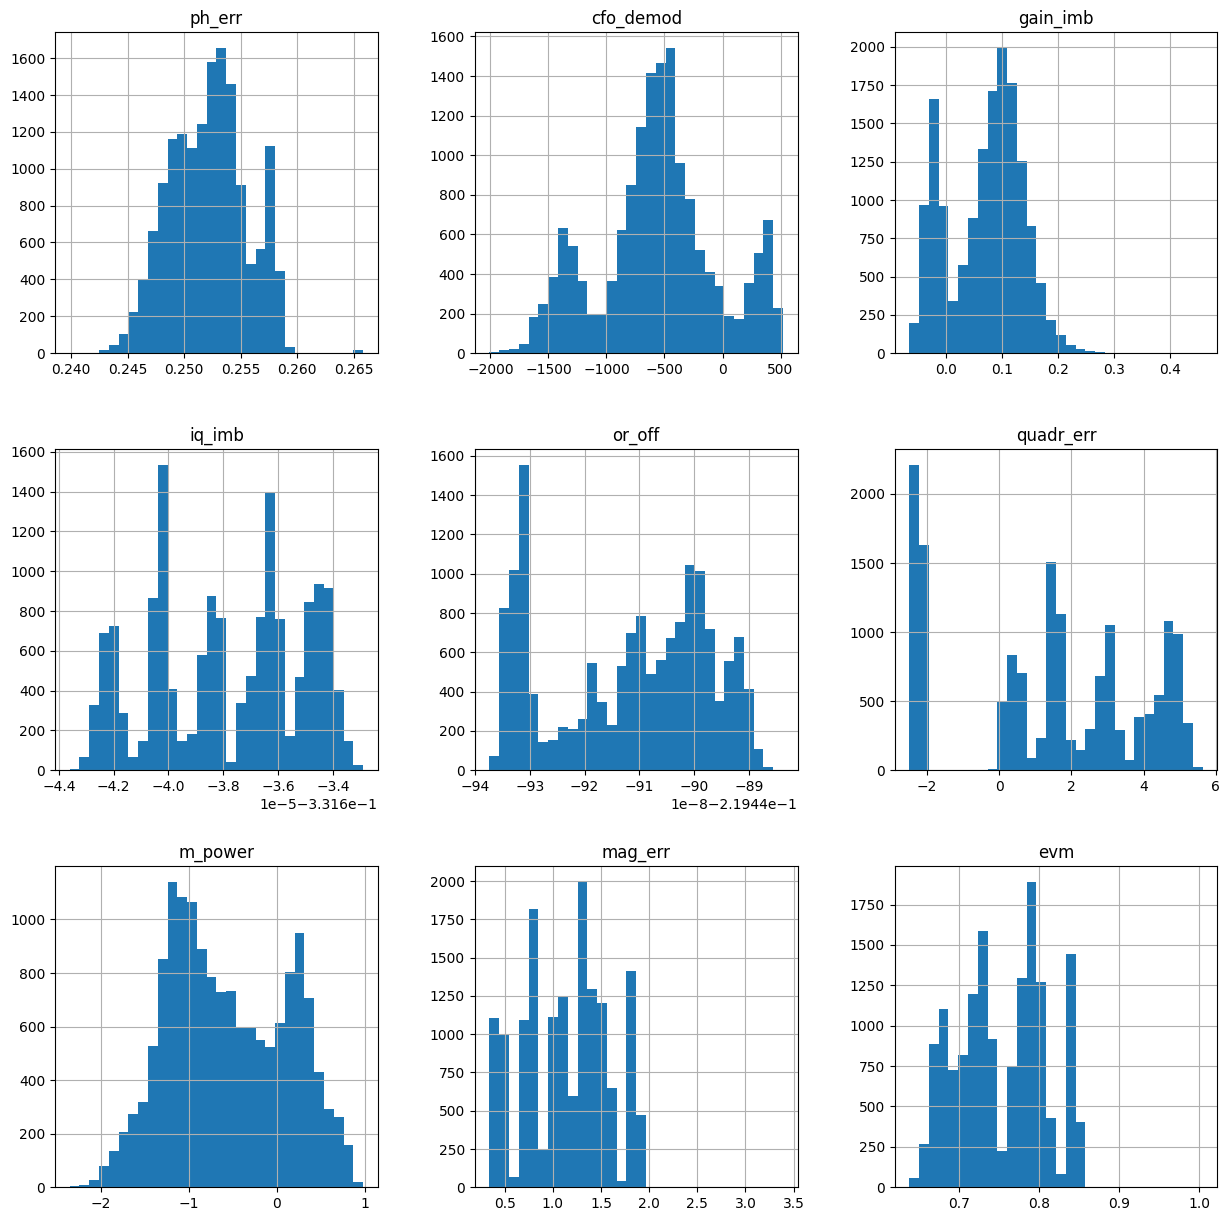

In [13]:
tmp = data.copy()

for var in cont_vars:

    tmp[var], param = stats.yeojohnson(data[var])

tmp[cont_vars].hist(bins=30, figsize=(15,15))
tmp.drop(['Tosc', 'Tmix'], axis = 1, inplace = True) 
plt.show()

In [14]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(tmp.values)
x = pd.DataFrame(x_scaled)
no_classes = targets['target'].max() + 1
y = to_categorical(targets['target'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

In [16]:
import keras_tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(len(cont_vars),)))
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=64, step=32),
                activation=hp.Choice("activation", ['relu', 'LeakyReLU'])
            )
        )
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
    model.add(Dense(no_classes, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=0.01, sampling="log")

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

build_model(keras_tuner.HyperParameters())

2023-03-25 12:34:24.202723: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-25 12:34:24.202748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Filip-HP): /proc/driver/nvidia/version does not exist
2023-03-25 12:34:24.203171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="transmitters"
)

In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'LeakyReLU'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)
tuner.search(X_train, y_train, epochs=8, validation_data=(X_val, y_val))

Trial 5 Complete [00h 00m 09s]
val_accuracy: 0.8809827566146851

Best val_accuracy So Far: 0.9987236857414246
Total elapsed time: 00h 00m 50s
INFO:tensorflow:Oracle triggered exit


In [28]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])

In [29]:
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.2,
          )

Epoch 1/30
111/111 [==============================] - 1s 5ms/step - loss: 1.8422 - accuracy: 0.3695 - val_loss: 1.3468 - val_accuracy: 0.5805
Epoch 2/30
111/111 [==============================] - 0s 2ms/step - loss: 1.0473 - accuracy: 0.6510 - val_loss: 0.6381 - val_accuracy: 0.8773
Epoch 3/30
111/111 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.8457 - val_loss: 0.3052 - val_accuracy: 0.9572
Epoch 4/30
111/111 [==============================] - 0s 2ms/step - loss: 0.2997 - accuracy: 0.9262 - val_loss: 0.1708 - val_accuracy: 0.9707
Epoch 5/30
111/111 [==============================] - 0s 2ms/step - loss: 0.1852 - accuracy: 0.9592 - val_loss: 0.0985 - val_accuracy: 0.9876
Epoch 6/30
111/111 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.9741 - val_loss: 0.0623 - val_accuracy: 0.9921
Epoch 7/30
111/111 [==============================] - 0s 3ms/step - loss: 0.0924 - accuracy: 0.9816 - val_loss: 0.0435 - val_accuracy: 0.9955
Epoch 

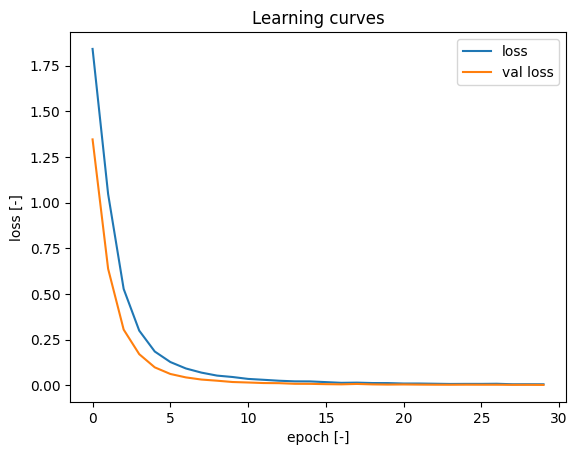

In [31]:
plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Learning curves")
plt.xlabel("epoch [-]")
plt.ylabel("loss [-]")

plt.legend()

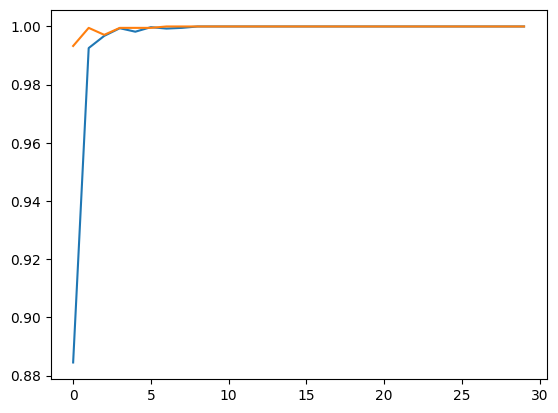

In [23]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [24]:
y_test = np.argmax(y_test, axis=1)

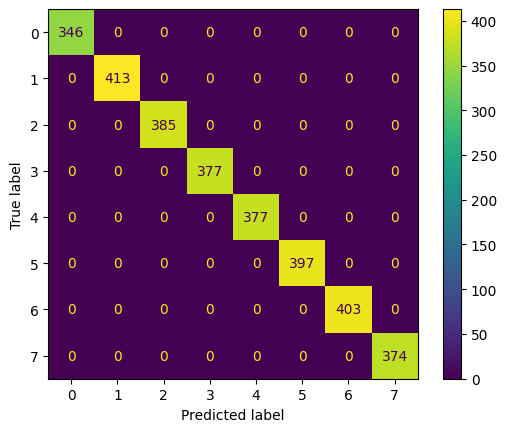

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
predictions = np.argmax(model.predict(X_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [26]:
# preparation of input data
test = pd.read_csv(r"./dataset/x_test.csv")
tmp = test.copy()

for var in cont_vars:

    tmp[var], param = stats.yeojohnson(test[var])

tmp.drop(['Unnamed: 0','Tosc', 'Tmix'], axis = 1, inplace = True) 
min_max_scaler = preprocessing.MinMaxScaler()
x_test_scaled = min_max_scaler.fit_transform(tmp.values)
x_test = pd.DataFrame(x_test_scaled)



In [27]:
test_predictions = np.argmax(model.predict(x_test, verbose=0), axis=1)

test_data = {'target': test_predictions}
df = pd.DataFrame(test_data)
df.index.name = 'id'
df.to_csv('results_v2.csv', index=True, encoding='utf-8')